In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-housing-prices/housing.csv


In [2]:
housing = pd.read_csv("../input/california-housing-prices/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


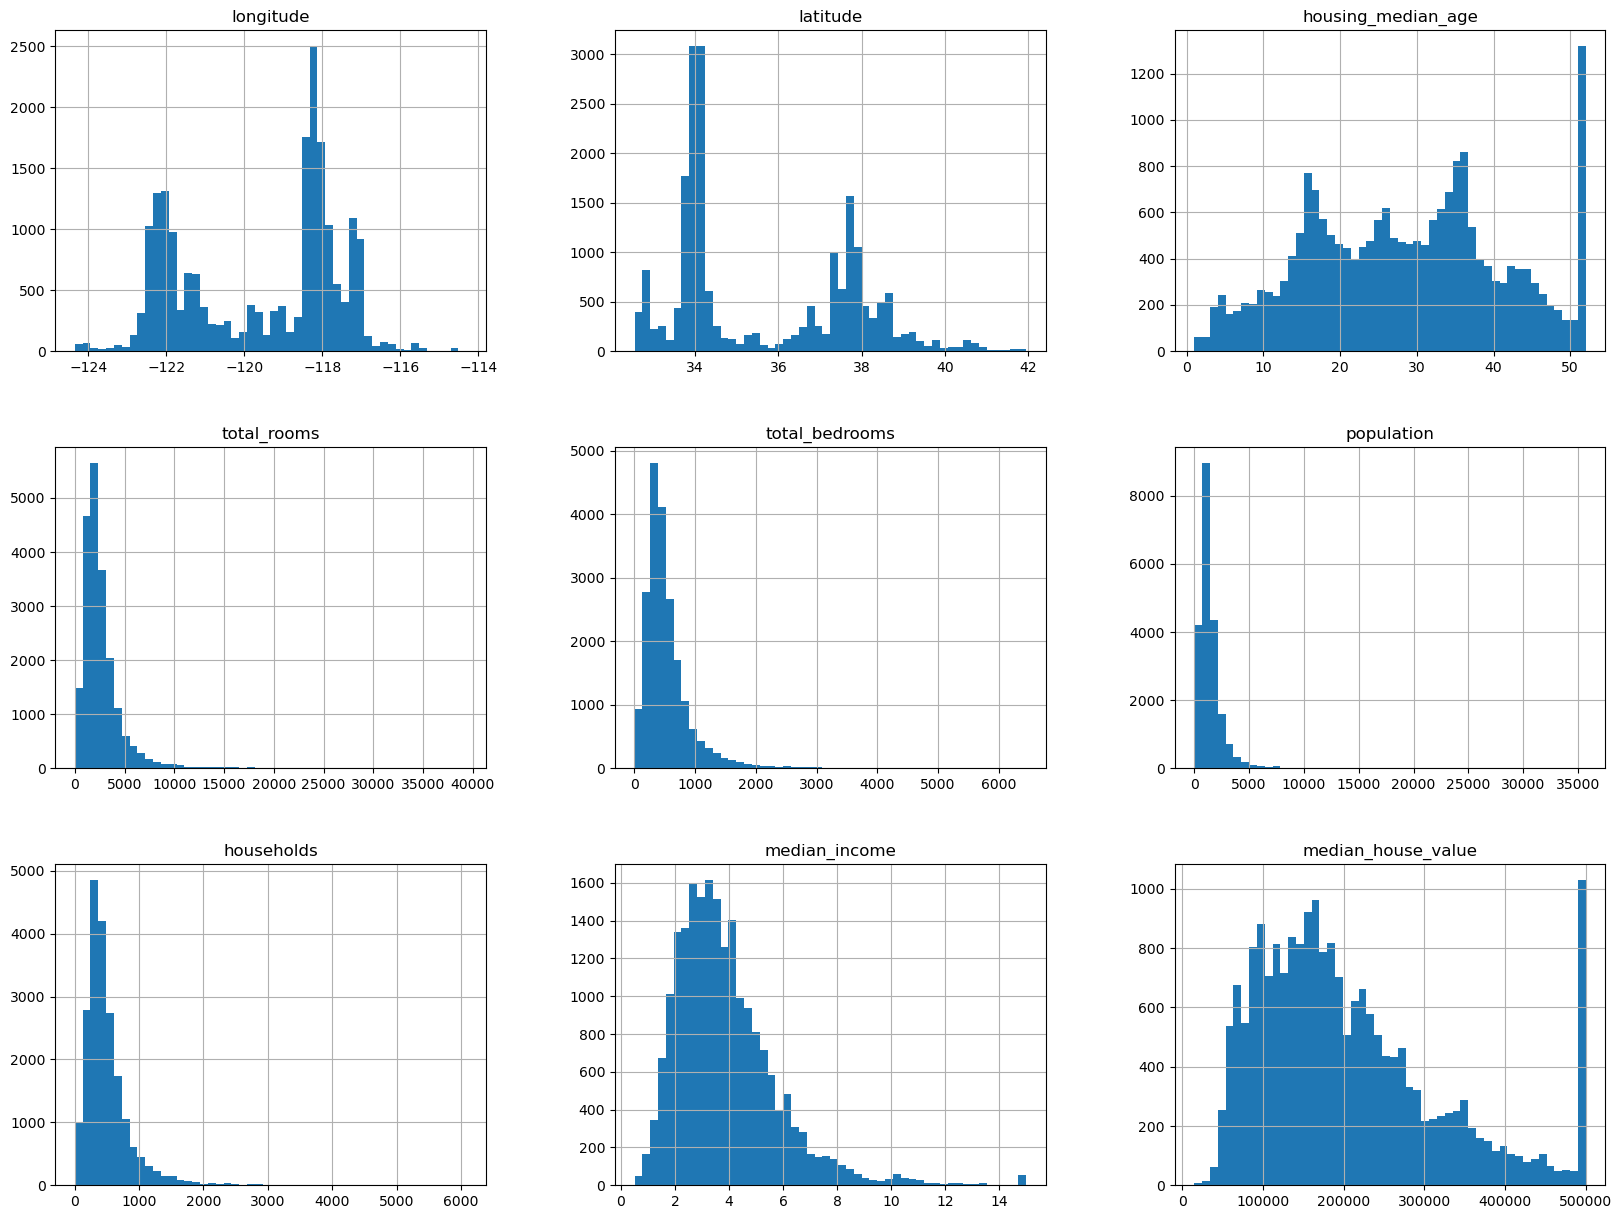

In [6]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
# creating own split_train_test
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

print(len(train_set))
print(len(test_set))

16512
4128


In [8]:
# using built in train_test_split from scikitlearn which does the same thing
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set)
len(test_set)

4128

<Axes: >

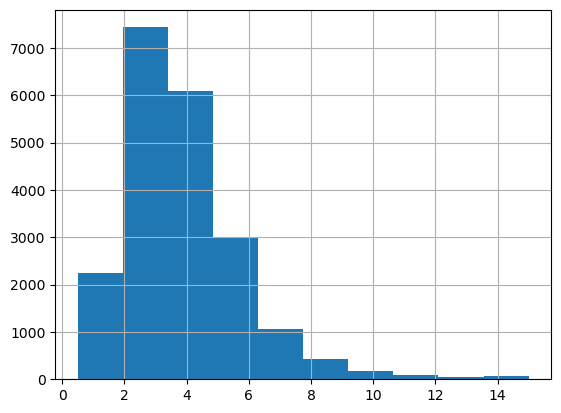

In [9]:
# now introducing a new column to categorize the data according to median_income
# lets see median_income histogram
housing['median_income'].hist()

<Axes: >

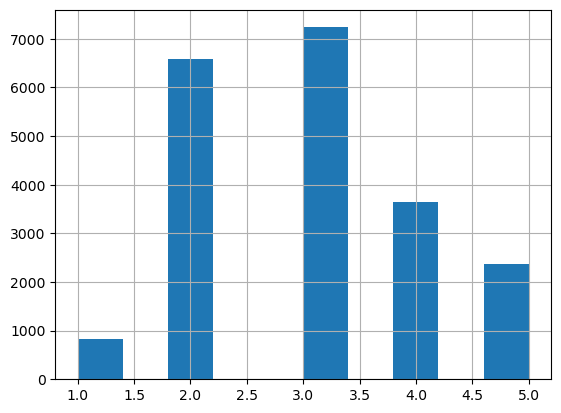

In [10]:

housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

In [11]:
# now its time to perform stratified sampling 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

stratified = strat_test_set['income_cat'].value_counts() / len(strat_test_set)

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
# housing = strat_train_set.copy()

In [12]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
random  = test_set['income_cat'].value_counts() / len(test_set)

In [13]:
overall = housing['income_cat'].value_counts()/len(housing)

In [14]:
# comparing the distributions of random and stratified sampling,
# from the below df we can see that stratified sampling distributes very nicely for the income_cat proportion
df = pd.concat([overall, random, stratified], keys = ['overall', 'random', 'stratified'], axis = 1)
df["random_error"] = ((df["random"] - df["overall"]) / df["overall"]) * 100
df["strat_error"] = ((df["stratified"] - df["overall"]) / df["overall"]) * 100

df

,overall,random,stratified,random_error,strat_error
3,0.350594,0.347563,0.350533,-0.864444,-0.017274
2,0.318859,0.308205,0.318798,-3.341398,-0.018993
4,0.176296,0.186497,0.176357,5.786345,0.034352
5,0.114462,0.112019,0.114341,-2.134183,-0.105820
1,0.039789,0.045716,0.039971,14.895411,0.456621


In [15]:
# now remove the extra attribute income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace=True)

In [16]:
housing = strat_train_set.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13027,-121.22,38.67,20.0,1412.0,226.0,700.0,227.0,4.0500,130700.0,INLAND
9783,-121.20,36.14,12.0,3738.0,710.0,2337.0,664.0,3.9647,135000.0,<1H OCEAN
19268,-122.74,38.43,11.0,4670.0,1007.0,2430.0,962.0,3.0341,142300.0,<1H OCEAN
14436,-117.24,32.80,28.0,1072.0,331.0,692.0,321.0,2.1357,187500.0,NEAR OCEAN
469,-122.29,37.87,46.0,1267.0,324.0,792.0,321.0,2.5250,165900.0,NEAR BAY


<Axes: xlabel='longitude', ylabel='latitude'>

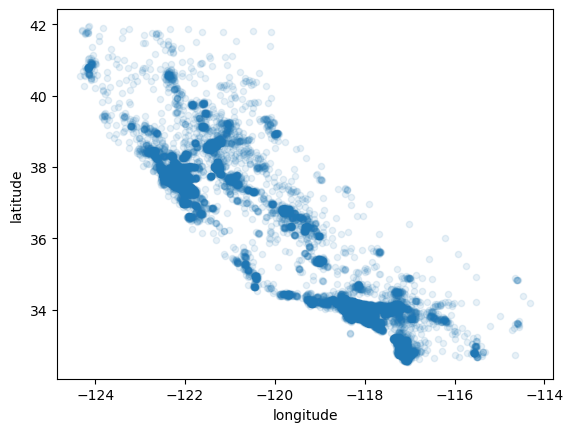

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

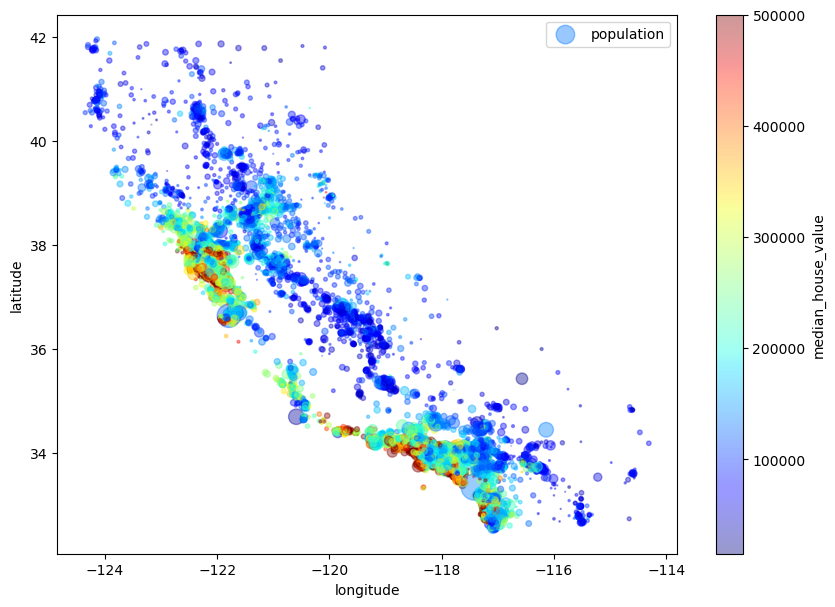

In [18]:
# we plot the graph to explore the data , and look for patterns and below one shows we can use clustring algorithms
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing['population']/100,
    label='population',
    figsize=(10, 7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True,
)

plt.legend()

In [19]:
housing_num = housing.drop("ocean_proximity", axis=1)
corr_matrix = housing_num.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686979
total_rooms           0.139821
housing_median_age    0.098470
households            0.069620
total_bedrooms        0.054386
population           -0.021894
longitude            -0.043389
latitude             -0.144899
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

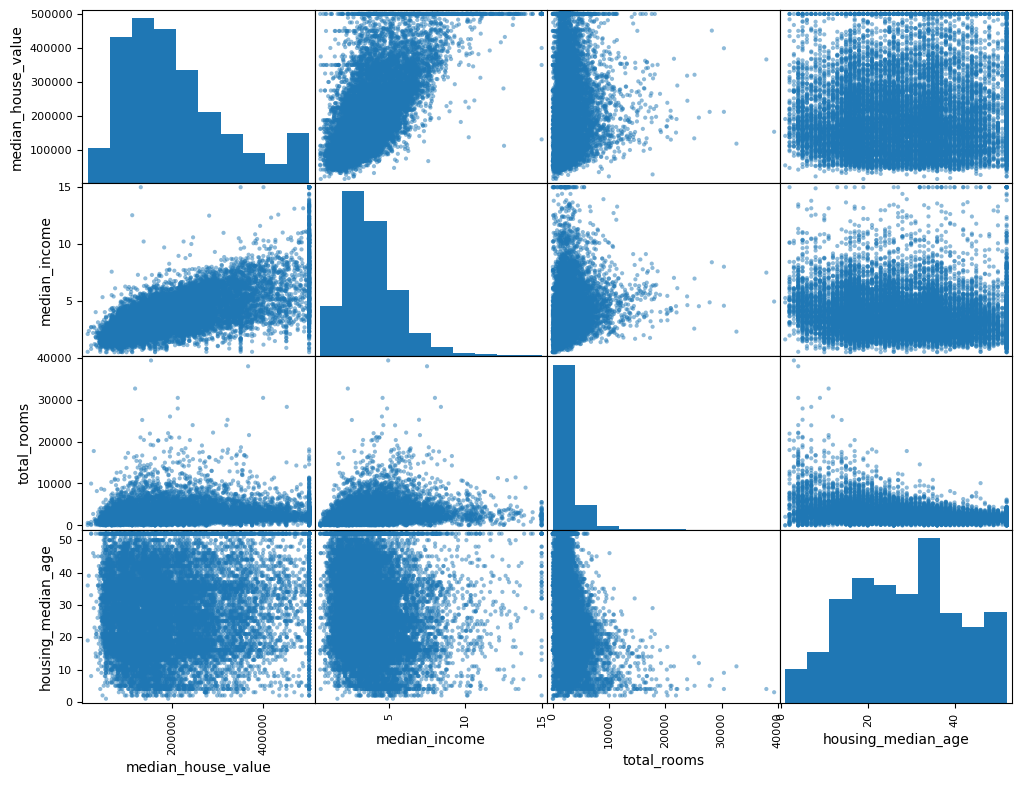

In [20]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 9))

<Axes: xlabel='median_income', ylabel='median_house_value'>

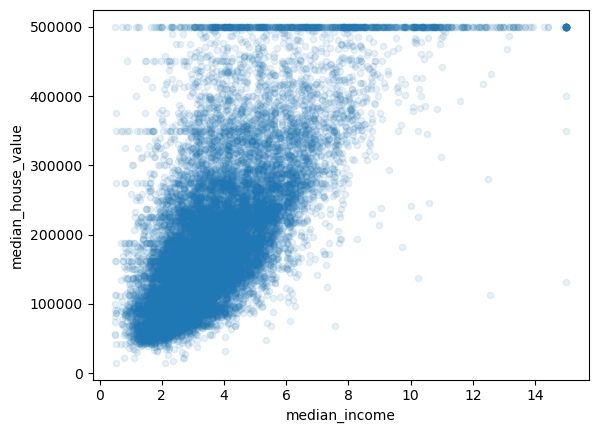

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha = 0.1)

In [22]:
# experimenting with attribute combinations

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

/tmp/ipykernel_21/4155107306.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.686979
rooms_per_household         0.154150
total_rooms                 0.139821
housing_median_age          0.098470
households                  0.069620
total_bedrooms              0.054386
population                 -0.021894
population_per_household   -0.027445
longitude                  -0.043389
latitude                   -0.144899
bedrooms_per_room          -0.256349
Name: median_house_value, dtype: float64

Here starts the data cleaning as we have
1. splitted train test set 
2. explored the dataset 
   plotted charts 
   and find cor-relation (if any )

In [23]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
13027,-121.22,38.67,20.0,1412.0,226.0,700.0,227.0,4.0500,130700.0,INLAND,6.220264,0.160057,3.083700
9783,-121.20,36.14,12.0,3738.0,710.0,2337.0,664.0,3.9647,135000.0,<1H OCEAN,5.629518,0.189941,3.519578
19268,-122.74,38.43,11.0,4670.0,1007.0,2430.0,962.0,3.0341,142300.0,<1H OCEAN,4.854470,0.215632,2.525988
14436,-117.24,32.80,28.0,1072.0,331.0,692.0,321.0,2.1357,187500.0,NEAR OCEAN,3.339564,0.308769,2.155763
469,-122.29,37.87,46.0,1267.0,324.0,792.0,321.0,2.5250,165900.0,NEAR BAY,3.947040,0.255722,2.467290


In [24]:
# here we will fill the nulls with median 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   rooms_per_household       16512 non-null  float64
 10  bedrooms_per_room         16512 non-null  float64
 11  population_per_household  16512 non-null  float64
dtypes: float64(12)
memory usage: 1.5 MB


In [25]:
# to handle categorical data, if they are important to the training
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:12]
# above encoding is useless because 
# <1H OCEAN     --->>> 0
# INLAND        --->>> 1
# NEAR OCEAN    --->>> 2
# NEAR BAY      --->>> 3
# ISLAND        --->>> 4
# and it is not useful maybe we could replace with a numerical distance from ocean

array([[1.],
       [0.],
       [0.],
       [4.],
       [3.],
       [0.],
       [4.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [26]:
# housing_cat.value_counts()
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [27]:
#another encoder one on the stage
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
13027,-121.22,38.67,20.0,1412.0,226.0,700.0,227.0,4.0500,130700.0,INLAND,6.220264,0.160057,3.083700
9783,-121.20,36.14,12.0,3738.0,710.0,2337.0,664.0,3.9647,135000.0,<1H OCEAN,5.629518,0.189941,3.519578
19268,-122.74,38.43,11.0,4670.0,1007.0,2430.0,962.0,3.0341,142300.0,<1H OCEAN,4.854470,0.215632,2.525988
14436,-117.24,32.80,28.0,1072.0,331.0,692.0,321.0,2.1357,187500.0,NEAR OCEAN,3.339564,0.308769,2.155763
469,-122.29,37.87,46.0,1267.0,324.0,792.0,321.0,2.5250,165900.0,NEAR BAY,3.947040,0.255722,2.467290
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18980,-122.00,38.25,7.0,11768.0,1893.0,6657.0,1874.0,4.9222,142900.0,INLAND,6.279616,0.160860,3.552295
17808,-121.87,37.41,17.0,3719.0,588.0,2089.0,561.0,6.7867,273700.0,<1H OCEAN,6.629234,0.158107,3.723708
7576,-118.21,33.88,29.0,1976.0,444.0,1254.0,371.0,2.1782,126800.0,<1H OCEAN,5.326146,0.224696,3.380054
5912,-118.44,34.29,32.0,1260.0,382.0,1434.0,342.0,2.0286,122900.0,<1H OCEAN,3.684211,0.303175,4.192982


In [28]:
# Custom transformers
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
#         print(rooms_per_household)
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [29]:
# feature scaling ( min-max scaling and standardization)
# transformation pipelines

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num = housing.drop("ocean_proximity", axis=1)
housing_num_tr = num_pipeline.fit_transform(housing_num)
len(housing_num_tr)

16512

In [30]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [31]:
# here comes finally training part
# first we will use LinearRegressor as we found some correlation bw target and feature attribute
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# testing our learned model with some data from training itself
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Prediction:", lin_reg.predict(some_data_prepared))

print("labels:", list(some_labels))

Prediction: [130700. 135000. 142300. 187500. 165900.]
labels: [130700.0, 135000.0, 142300.0, 187500.0, 165900.0]


In [32]:
from sklearn.metrics import mean_squared_error
    
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

# the above seems that it has overfitted the data, lets try decisiontreeregressor

8.636009260571709e-11

In [33]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

0.0

In [34]:
# lets try cross-validation 
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

# on distributed the training dataset into 10 parts and training with 9 and testing with 1, we are getting scores for each iterations ( 10 ), 
# and we found each are having error and mean error comes out to be 130 and min-max errors are 130 +_ 53

Scores: [106.09455158 231.54000826  83.60444492 115.55307972  88.76977348
  96.95547131  94.61580318  87.77483445 151.53165118 116.68757564]
Mean: 117.31271937095433
Standard deviation: 42.54544037958567


In [35]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [1.10303533e-10 1.02381799e-10 4.63393182e-10 1.38600049e-10
 1.14969664e-10 1.12691338e-10 8.91201934e-11 1.34600124e-10
 1.10731459e-10 1.06933702e-10]
Mean: 1.483725042894696e-10
Standard deviation: 1.0588737069933176e-10
